## Train CFM

In [1]:
import numpy as np
import torch
from DynGenModels.configs.lhco_configs import LHCOlympics_HighLevel_MLP_CondFlowMatch as Configs

configs = Configs(# data:
                  DATA = 'LHCOlympics',
                  dataset = '../../data/LHCOlympics2020/events_anomalydetection_high_level_cathode.h5', 
                  cuts_sideband_low = {'mjj': [2600, 3200]},  
                  cuts_sideband_high = {'mjj': [3800, 4400]}, 
                  preprocess = None,
                  dim_input = 5,
                  num_dijets = 75166,  
                  # training params:   
                  DEVICE = 'cuda:1',
                  EPOCHS = 100,
                  batch_size = 512,
                  print_epochs = 20,
                  early_stopping = 30,
                  min_epochs = 200,
                  data_split_fracs = [0.9, 0.1, 0.0],
                  lr = 5e-4,
                  optimizer = 'Adam',
                  fix_seed = 12234,
                  # model params:
                  MODEL = 'MLP',
                  dim_hidden = 256,
                  num_layers = 3,
                  sigma = 0.0,
                  t0 = 0.0,
                  t1 = 1.0,
                  # sampling params:
                  solver = 'midpoint',
                  num_sampling_steps = 1000
                )

configs.set_workdir(path='../../results', save_config=True)

#=====================================================================================
INFO: created directory: ../../results/LHCOlympics.CondFlowMatch.MLP.2023.11.11_19h16
#=====================================================================================
+---------------------+--------------------------------------------------------------------------+
| Parameters          | Values                                                                   |
+---------------------+--------------------------------------------------------------------------+
| DATA                | LHCOlympics                                                              |
| dataset             | ../../data/LHCOlympics2020/events_anomalydetection_high_level_cathode.h5 |
| features            | ['mjj', 'mj1', 'delta_m', 'tau21_1', 'tau21_2']                          |
| dim_input           | 5                                                                        |
| preprocess          |                        

### 1. Forward transport SB1->SB2

2023-11-11 19:16:42.934715: I tensorflow/core/platform/cpu_feature_guard.cc:182] This TensorFlow binary is optimized to use available CPU instructions in performance-critical operations.
To enable the following instructions: AVX2 AVX512F FMA, in other operations, rebuild TensorFlow with the appropriate compiler flags.
2023-11-11 19:16:43.539224: W tensorflow/compiler/tf2tensorrt/utils/py_utils.cc:38] TF-TRT Warning: Could not find TensorRT
/home/df630/DynGenModels/src/DynGenModels/datamodules/lhco/datasets.py:47: UserWarning: Creating a tensor from a list of numpy.ndarrays is extremely slow. Please consider converting the list to a single numpy.ndarray with numpy.array() before converting to a tensor. (Triggered internally at  ../torch/csrc/utils/tensor_new.cpp:204.)
  dijets = torch.Tensor(f['jet features'])
/home/df630/DynGenModels/src/DynGenModels/datamodules/lhco/dataprocess.py:40: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() 

INFO: building dataloaders...
INFO: train/val/test split ratios: 0.9/0.1/0.0
INFO: train size: 67649, validation size: 7516, testing sizes: 0


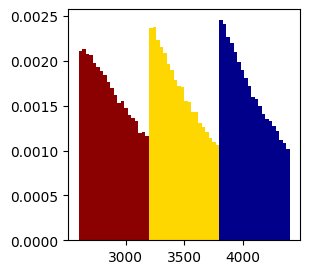

number of training parameters: 134661
start training...


epochs:   0%|          | 0/100 [00:00<?, ?it/s]

	Epoch: 1, train loss: 4507.25697728207, valid loss: 4618.437272135417  (min valid loss: 4618.437272135417)
	Epoch: 21, train loss: 4479.635602678569, valid loss: 4328.737613932292  (min valid loss: 4328.737613932292)
	Epoch: 41, train loss: 4034.4236060121034, valid loss: 3983.1424641927083  (min valid loss: 3983.1424641927083)
	Epoch: 61, train loss: 2322.260327332001, valid loss: 2322.7612223307287  (min valid loss: 1789.8306640625)
	Epoch: 81, train loss: 2045.1996941817426, valid loss: 2273.2173583984377  (min valid loss: 1693.999959309896)


In [2]:
from DynGenModels.datamodules.lhco.datasets import LHCOlympicsHighLevelDataset
from DynGenModels.datamodules.lhco.dataloader import LHCOlympicsDataLoader 
from DynGenModels.models.deep_nets import MLP
from DynGenModels.dynamics.cnf.condflowmatch import OptimalTransportFlowMatching
from DynGenModels.trainer.trainer import DynGenModelTrainer

lhco_forward = LHCOlympicsHighLevelDataset(configs)
cfm_forward  = DynGenModelTrainer(dynamics = OptimalTransportFlowMatching(configs),
                         model = MLP(configs), 
                         dataloader = LHCOlympicsDataLoader(lhco_forward , configs), 
                         configs = configs)

import matplotlib.pyplot as plt

fig, ax = plt.subplots(figsize=(3, 3))
plt.hist(lhco_forward.source[:, 0], bins=20, histtype='stepfilled', color='darkred', density=True)
plt.hist(lhco_forward.target[:, 0], bins=20, histtype='stepfilled', color='darkblue', density=True)
plt.hist(lhco_forward.background[:, 0], bins=20, histtype='stepfilled', color='gold', density=True)
plt.show()

#...train model:

cfm_forward.train()

In [ ]:
from DynGenModels.pipelines.SamplingPipeline import FlowMatchPipeline 

pipeline_forward = FlowMatchPipeline(trained_model=cfm_forward, 
                             configs=configs, 
                             best_epoch_model=True)

pipeline_forward.generate_samples(input_source=lhco_forward.source)

### 2. Backward transport SB2->SB1

In [9]:
from DynGenModels.datamodules.lhco.datasets import LHCOlympicsHighLevelDataset
from DynGenModels.datamodules.lhco.dataloader import LHCOlympicsDataLoader 
from DynGenModels.models.deep_nets import MLP
from DynGenModels.dynamics.cnf.condflowmatch import OptimalTransportFlowMatching
from DynGenModels.trainer.trainer import DynGenModelTrainer

lhco_backward = LHCOlympicsHighLevelDataset(configs, exchange_target_with_source=True)
cfm_backward = DynGenModelTrainer(dynamics = OptimalTransportFlowMatching(configs),
                         model = MLP(configs), 
                         dataloader = LHCOlympicsDataLoader(lhco_backward, configs), 
                         configs = configs)


#...train model:

cfm_backward.train()

/home/df630/DynGenModels/src/DynGenModels/datamodules/lhco/dataprocess.py:40: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  self.features = torch.tensor(self.features[:self.num_dijets])
number of training parameters: 134661
start training...


INFO: building dataloaders...
INFO: train/val/test split ratios: 0.9/0.1/0.0
INFO: train size: 67649, validation size: 7516, testing sizes: 0


epochs:   0%|          | 0/100 [00:00<?, ?it/s]

	Epoch: 1, train loss: 4629.756779032543, valid loss: 4590.69873046875  (min valid loss: 4590.69873046875)
	Epoch: 21, train loss: 4533.74189196135, valid loss: 4494.772395833334  (min valid loss: 4494.772395833334)
	Epoch: 41, train loss: 3504.159326539004, valid loss: 3854.617952473958  (min valid loss: 3792.092464192708)
	Epoch: 61, train loss: 1959.0177231408595, valid loss: 1750.814501953125  (min valid loss: 1750.814501953125)
	Epoch: 81, train loss: 1771.6281995271374, valid loss: 1486.0213623046875  (min valid loss: 1486.0213623046875)


In [3]:
bool(0)

False

In [17]:
from DynGenModels.pipelines.SamplingPipeline import FlowMatchPipeline 
from DynGenModels.datamodules.lhco.dataprocess import PreProcessLHCOlympicsHighLevelData, PostProcessLHCOlympicsHighLevelData

pipeline_backward = FlowMatchPipeline(trained_model=cfm_backward, 
                             configs=configs, 
                             best_epoch_model=True)

pipeline_backward.generate_samples(input_source=lhco_backward.target)

INFO: neural ODE solver with midpoint method and steps=1000


/home/df630/.conda/envs/flow_match_env/lib/python3.9/site-packages/torchdyn/numerics/odeint.py:84: UserWarning: Setting tolerances has no effect on fixed-step methods
  warn("Setting tolerances has no effect on fixed-step methods")


/tmp/ipykernel_63263/2648179893.py:49: MatplotlibDeprecationWarning: Passing the emit parameter of set_ylim() positionally is deprecated since Matplotlib 3.6; the parameter will become keyword-only two minor releases later.
  ax_ratio.set_ylim(0.8, 1.2, 0)
/tmp/ipykernel_63263/2648179893.py:56: MatplotlibDeprecationWarning: The label function was deprecated in Matplotlib 3.1 and will be removed in 3.8. Use Tick.label1 instead.
  tick.label.set_fontsize(9)
/tmp/ipykernel_63263/2648179893.py:58: MatplotlibDeprecationWarning: The label function was deprecated in Matplotlib 3.1 and will be removed in 3.8. Use Tick.label1 instead.
  tick.label.set_fontsize(9)


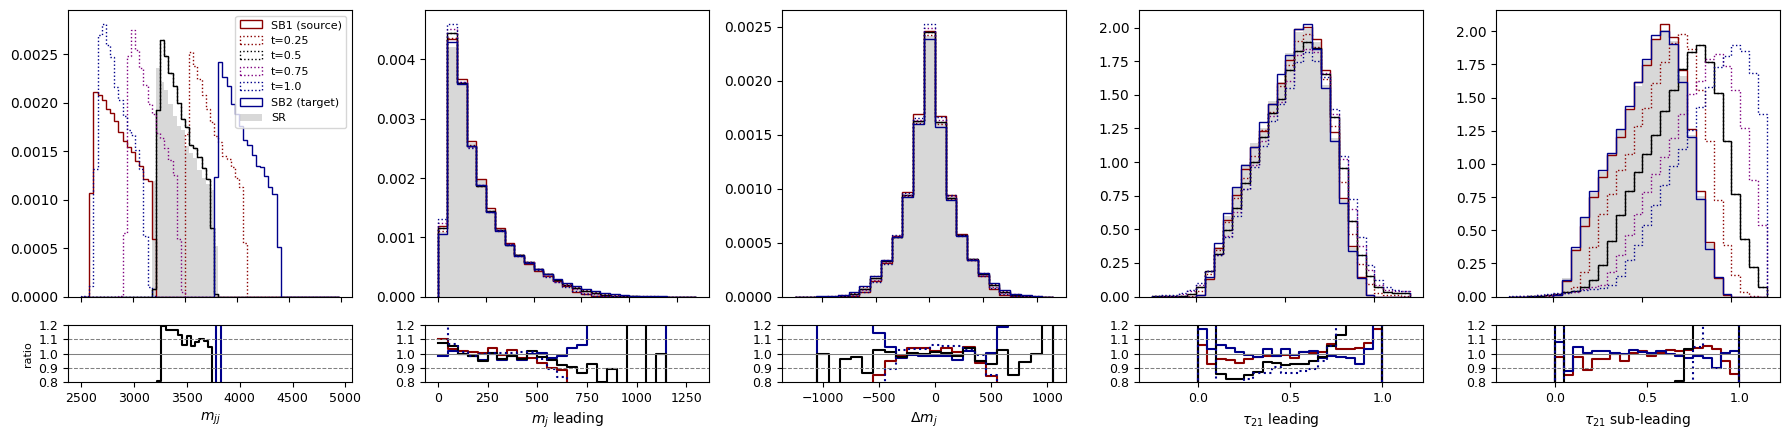

In [19]:
from utils import plot_interpolation

plot_interpolation(lhco_backward, 
                    pipeline_backward, 
                    figsize=(18,4.5),
                    mass_window=[configs.cuts_sideband_low['mjj'][1], configs.cuts_sideband_high['mjj'][0]], 
                    bins=[(2500, 5000, 40), (0, 1400, 50), (-1250, 1250, 100), (-0.25, 1.25, 0.05), (-0.25, 1.25, 0.05)], 
                    log=False, 
                    density=True)

/tmp/ipykernel_63263/2186551730.py:49: MatplotlibDeprecationWarning: Passing the emit parameter of set_ylim() positionally is deprecated since Matplotlib 3.6; the parameter will become keyword-only two minor releases later.
  ax_ratio.set_ylim(0.8, 1.2, 0)
/tmp/ipykernel_63263/2186551730.py:56: MatplotlibDeprecationWarning: The label function was deprecated in Matplotlib 3.1 and will be removed in 3.8. Use Tick.label1 instead.
  tick.label.set_fontsize(9)
/tmp/ipykernel_63263/2186551730.py:58: MatplotlibDeprecationWarning: The label function was deprecated in Matplotlib 3.1 and will be removed in 3.8. Use Tick.label1 instead.
  tick.label.set_fontsize(9)


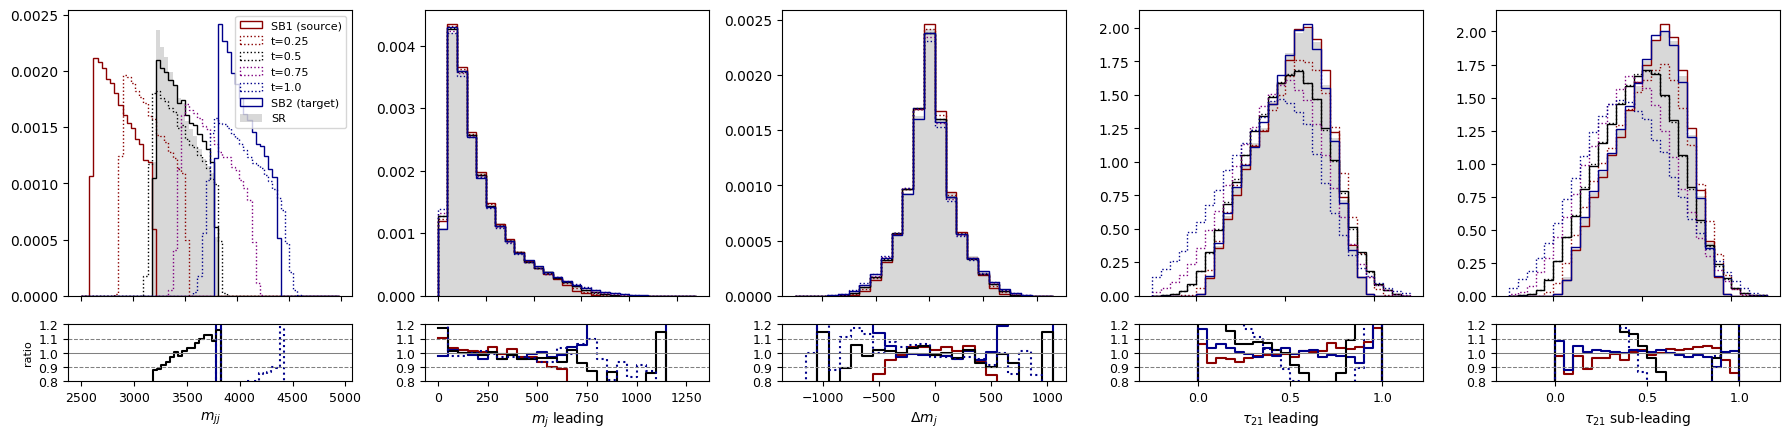

In [5]:
from utils import plot_interpolation

plot_interpolation(lhco_forward, 
                    pipeline_backward, 
                    figsize=(18,4.5),
                    mass_window=[configs.cuts_sideband_low['mjj'][1], configs.cuts_sideband_high['mjj'][0]], 
                    bins=[(2500, 5000, 40), (0, 1400, 50), (-1250, 1250, 100), (-0.25, 1.25, 0.05), (-0.25, 1.25, 0.05)], 
                    log=False, 
                    density=True)

/tmp/ipykernel_63263/4032748329.py:49: MatplotlibDeprecationWarning: Passing the emit parameter of set_ylim() positionally is deprecated since Matplotlib 3.6; the parameter will become keyword-only two minor releases later.
  ax_ratio.set_ylim(0.8, 1.2, 0)
/tmp/ipykernel_63263/4032748329.py:56: MatplotlibDeprecationWarning: The label function was deprecated in Matplotlib 3.1 and will be removed in 3.8. Use Tick.label1 instead.
  tick.label.set_fontsize(9)
/tmp/ipykernel_63263/4032748329.py:58: MatplotlibDeprecationWarning: The label function was deprecated in Matplotlib 3.1 and will be removed in 3.8. Use Tick.label1 instead.
  tick.label.set_fontsize(9)


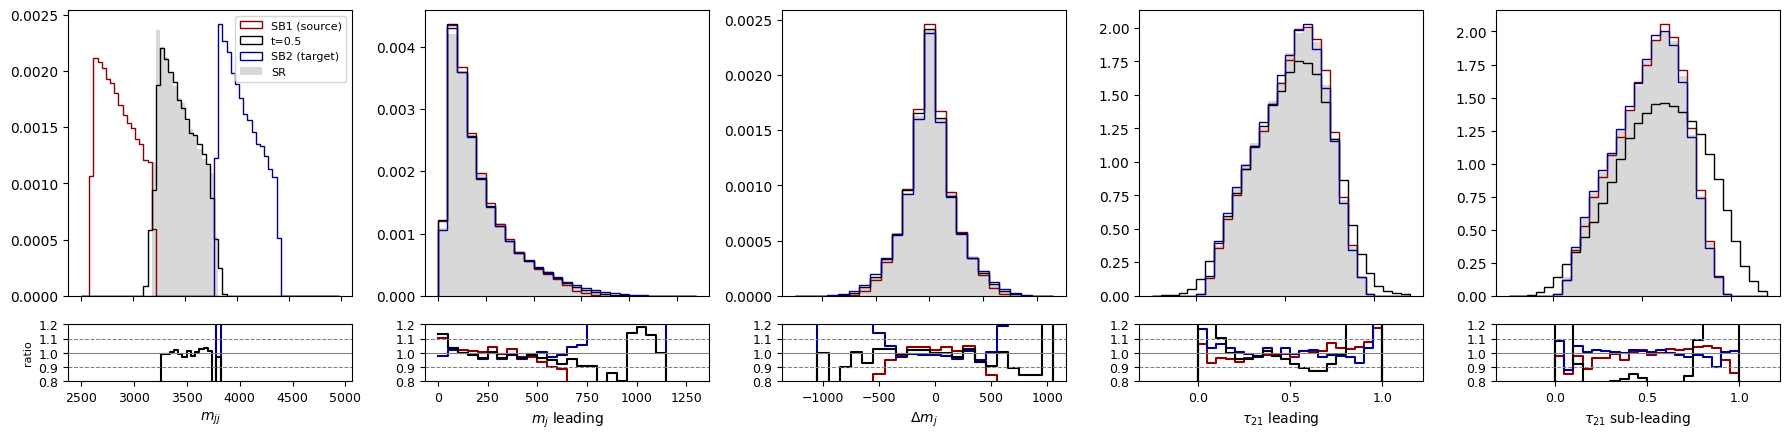

In [34]:
from utils import plot_interpolation_combined



def plot_interpolation_combined(lhco, pipeline_forward, pipeline_backward, mass_window, figsize=(14,6), 
                                features=[r'$m_{jj}$', r'$m_{j}$ leading', r'$\Delta m_j$', r'$\tau_{21}$ leading',  r'$\tau_{21}$ sub-leading'],
                                bins=[(2500, 5000, 30), (0, 1400, 50), (-1250, 1250, 100), (-0.25, 1.25, 0.025), (-0.25, 1.25, 0.025)], 
                                log=True, density=True):
    
    x_forward = torch.mean(pipeline_forward.trajectories[...,0], dim=-1) - lhco.background[...,0].mean()
    idx_forward = torch.argmin(torch.abs(x_forward))
    interpolation_forward = pipeline_forward.trajectories[idx_forward]  

    x_backward = torch.mean(pipeline_backward.trajectories[...,0], dim=-1) - lhco.background[...,0].mean()
    idx_backward = torch.argmin(torch.abs(x_backward))
    interpolation_backward = pipeline_backward.trajectories[idx_backward] 

    interpolation = torch.cat([interpolation_forward, interpolation_backward], dim=0)

    fig, axs = plt.subplots(2, 5, figsize=figsize, gridspec_kw={'height_ratios': [5, 1]})

    for f in range(len(features)):
        b = np.arange(*bins[f])

        # Top row: Plotting the histograms
        ax = axs[0, f]
        ax.hist(lhco.source[...,f], bins=b, histtype='step', color='darkred', label='SB1 (source)', log=log, density=density)
        ax.hist(interpolation[...,f], bins=b, histtype='step', color='k', label='t=0.5', log=log, density=density)
        ax.hist(lhco.target[...,f], bins=b, histtype='step', color='darkblue',  label='SB2 (target)', log=log, density=density)
        ax.hist(lhco.background[...,f],bins=b, histtype='stepfilled', color='gray', alpha=0.3, label='SR', log=log, density=density)
        ax.set_xticklabels([])  # Hide x-axis labels for the top row
        if f==0: ax.legend(loc='upper right', fontsize=8)

        # Second row: Plotting the ratio of histograms
        counts_sb1, _ = np.histogram(lhco.source[...,f], bins=b, density=density)
        counts_sb2, _ = np.histogram(lhco.target[...,f], bins=b, density=density)
        counts_interpolation, _ = np.histogram(interpolation[...,f], bins=b, density=density)
        counts_background, _ = np.histogram(lhco.background[...,f], bins=b, density=density)


        ratio_sb1 = np.divide(counts_sb1, counts_background, out=np.zeros_like(counts_sb1), where=counts_background!=0)
        ratio_sb2 = np.divide(counts_sb2, counts_background, out=np.zeros_like(counts_sb2), where=counts_background!=0)
        ratio_interpolation = np.divide(counts_interpolation, counts_background, out=np.zeros_like(counts_interpolation), where=counts_background!=0)

        ax_ratio = axs[1, f]
        ax_ratio.plot(b[:-1], ratio_sb1, drawstyle='steps-post', color='darkred')
        ax_ratio.plot(b[:-1], ratio_sb2, drawstyle='steps-post', color='darkblue')
        ax_ratio.plot(b[:-1], ratio_interpolation, drawstyle='steps-post', color='k')
        ax_ratio.set_ylim(0.8, 1.2, 0) 
        ax_ratio.set_xlabel(features[f])
        ax_ratio.axhline(1, color='gray', linestyle='-', lw=0.75)
        ax_ratio.axhline(0.9, color='gray', linestyle='--', lw=0.75)
        ax_ratio.axhline(1.1, color='gray', linestyle='--', lw=0.75)

        for tick in ax_ratio.xaxis.get_major_ticks():
            tick.label.set_fontsize(9)
        for tick in ax_ratio.yaxis.get_major_ticks():
            tick.label.set_fontsize(9)  
        if f == 0:
            ax_ratio.set_ylabel('ratio', fontsize=8)
        ax_ratio.set_yticks([0.8,  0.9,  1,  1.1,  1.2])

    plt.tight_layout()
    plt.show()

plot_interpolation_combined(lhco, pipeline, pipeline_backwards, 
                            mass_window=[configs.cuts_sideband_low['mjj'][1], configs.cuts_sideband_high['mjj'][0]], 
                            figsize=(18,4.5),
                            bins=[(2500, 5000, 40), (0, 1400, 50), (-1250, 1250, 100), (-0.25, 1.25, 0.05), (-0.25, 1.25, 0.05)], 
                            log=False, 
                            density=True)

/tmp/ipykernel_3831699/642011689.py:79: MatplotlibDeprecationWarning: Passing the emit parameter of set_ylim() positionally is deprecated since Matplotlib 3.6; the parameter will become keyword-only two minor releases later.
  ax_ratio.set_ylim(0.8, 1.2, 0)
/tmp/ipykernel_3831699/642011689.py:86: MatplotlibDeprecationWarning: The label function was deprecated in Matplotlib 3.1 and will be removed in 3.8. Use Tick.label1 instead.
  tick.label.set_fontsize(9)
/tmp/ipykernel_3831699/642011689.py:88: MatplotlibDeprecationWarning: The label function was deprecated in Matplotlib 3.1 and will be removed in 3.8. Use Tick.label1 instead.
  tick.label.set_fontsize(9)


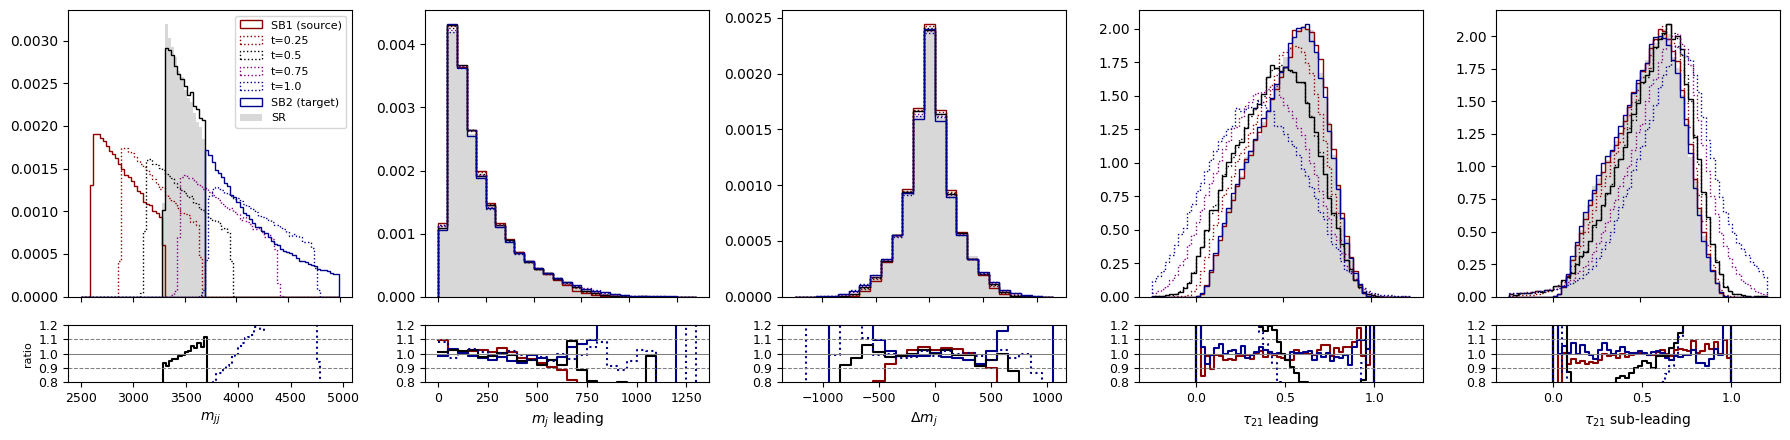

In [87]:
plot_interpolation(lhco, 
                    pipeline, 
                    figsize=(18,4.5),
                    mass_window=[configs.cuts_sideband_low['mjj'][1], configs.cuts_sideband_high['mjj'][0]], 
                    bins=[(2500, 5000, 30), (0, 1400, 50), (-1250, 1250, 100), (-0.25, 1.25, 0.025), (-0.25, 1.25, 0.025)], 
                    log=False, 
                    density=True)

# Sample from Pretrained CFM

Load a previsoiusly trained model that was stored somewhere in a directory. The directory must contain the follwing files:
- `config.json` file with all the parameters used during the training.
- `best_epoch_model.pth` model file corresponding the trained model that had the lowest validation loss.
- `last_epoch_model.pth` model file corresponding the last epoch trained model.


### 1. Load pre-trained model
promising runs:

 - LHCOlympics.CondFlowMatch.MLP.2023.11.01_22h09
 

In [ ]:
#...provide the directory of the trained model and load the configuration file in it:

from DynGenModels.configs.lhco_configs import LHCOlympics_MLP_CondFlowMatch as Configs

model_workdir = '../../results/LHCOlympics.CondFlowMatch.MLP.2023.11.01_22h09'
configs = Configs().load(model_workdir + '/config.json')
configs.DEVICE = 'cuda:3'   # select device
configs.workdir = model_workdir

#...be sure to use the same dataset, dataloader and model that was used for training the pre-trained model:

from DynGenModels.datamodules.lhco.datasets import LHCOlympicsDataset 
from DynGenModels.datamodules.lhco.dataloader import LHCOlympicsDataLoader 
from DynGenModels.models.deep_nets import MLP
from DynGenModels.dynamics.cnf.condflowmatch import SimplifiedCondFlowMatching
from DynGenModels.trainer.trainer import DynGenModelTrainer

lhco = LHCOlympicsDataset(configs)
pretrained_cfm = DynGenModelTrainer(dynamics = SimplifiedCondFlowMatching(configs),
                                    model = MLP(configs), 
                                    dataloader = LHCOlympicsDataLoader(lhco, configs), 
                                    configs = configs)

#...load the pre-trained model:

pretrained_cfm.load(model='best')

### 2. sample from loaded models

In [6]:
from DynGenModels.pipelines.SamplingPipeline import FlowMatchPipeline 

pipeline = FlowMatchPipeline(trained_model=pretrained_cfm, 
                             source_input=lhco.source,
                             configs=configs, 
                             solver = 'dopri5',
                             best_epoch_model=True)

NameError: name 'pretrained_cfm' is not defined

### Plot results:

In [ ]:
import numpy as np
from utils import plot_jet_features, plot_dijet_mass

STEP = configs.num_sampling_steps/2
D_STEP = configs.num_sampling_steps/4

plot_jet_features(lhco, pipeline.trajectories, 'p_t', time_step=STEP, d_step=D_STEP, xlim=(1000, 3000, 40))
plot_jet_features(lhco, pipeline.trajectories, '\eta', time_step=STEP, d_step=D_STEP, xlim=(-3, 3, 0.05))
plot_jet_features(lhco, pipeline.trajectories, '\phi', time_step=STEP, d_step=D_STEP, xlim=(-1, 12, 0.1))
plot_jet_features(lhco, pipeline.trajectories, 'm', time_step=STEP, d_step=D_STEP, xlim=(0, 1000, 10))
plot_dijet_mass(lhco, pipeline.trajectories, bins=np.arange(2000, 10000, 20), time_step=STEP, d_step=D_STEP, figsize=(4,4))